In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import random
import json
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import optuna

e:\Projects\Github\Predicting-Bitcoin-Returns-with-Long-Short-Term-Memory-LSTM-Neural-Networks\btc-pred\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

CUDA is available.
CUDA device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 2060


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Set seeds

In [4]:
seed_value = 52
torch.manual_seed(seed_value)

## Prepare Data 


Additionally, visualize the data

In [5]:
#Load in data
with open('config.json') as f:
    config = json.load(f)

data_path = config["bit-finex"]

df = pd.read_csv(data_path)

ts = df["close"].values

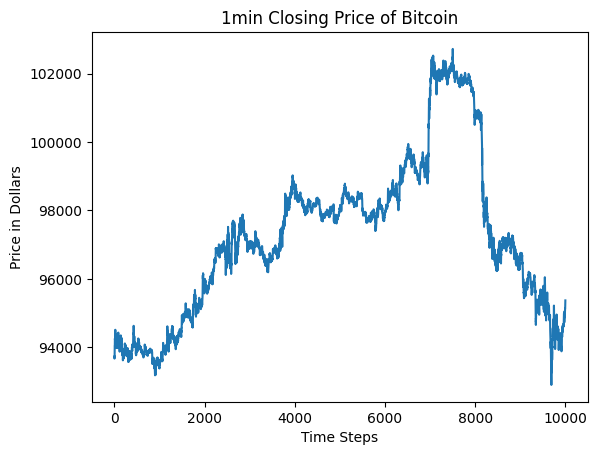

In [6]:
plt.plot(ts, label="observations")
plt.title('1min Closing Price of Bitcoin')
plt.xlabel('Time Steps')
plt.ylabel('Price in Dollars')
plt.savefig('graphs/btc-price.png')
plt.show()

## Preprocessing Data

Check dimensions

In [7]:
print(ts.shape)
ts = ts.reshape(-1,1)
print(ts.shape)

(10000,)
(10000, 1)


Training-Validation-Testing Split

In [8]:
# train-test split for time series
train_size = int(len(ts) * 0.70)
train, rest = ts[:train_size], ts[train_size:]
validation_size = int(len(rest) * 0.50)
validation, test = rest[:validation_size], rest[validation_size:]

print(len(train))
print(len(validation))
print(len(test))

7000
1500
1500


Feature Scaling

In [9]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
valid_scaled = scaler.fit_transform(validation)
test_scaled = scaler.fit_transform(test)

## Hyper Parameter Optimization

In [13]:
class LSTM(nn.Module):
    def __init__(self, hidden_size, num_layers,):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x


In [14]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

In [15]:
study = optuna.create_study(
    study_name="lstm-btc-1",
    storage="sqlite:///study.db",  # Save to SQLite file,
    direction='minimize',
    load_if_exists=True  # Load existing study if it exists
)

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_size = trial.suggest_int("hidden_size", 100, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    lookback = trial.suggest_int("lookback", 1, 30)

    # Create datasets
    X_train, y_train = create_dataset(train_scaled, lookback)
    X_valid, y_valid = create_dataset(valid_scaled, lookback)   
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).to(device)
    y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).to(device)

    # Initialize the model
    model = LSTM(hidden_size=hidden_size, num_layers=num_layers)
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.MSELoss()
    train_loader = data.DataLoader(data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

    # Training loop
    n_epochs = 50
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation evaluation
        model.eval()
        with torch.no_grad():
            y_valid_pred = model(X_valid_tensor)
            valid_rmse = torch.sqrt(loss_fn(y_valid_tensor, y_valid_pred))

        trial.report(valid_rmse, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_rmse

# Initialize Optuna study and optimize
study.optimize(objective, n_trials=100)
best_params = study.best_params

# Best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

[I 2025-01-15 16:25:36,107] A new study created in RDB with name: lstm-btc-1
[I 2025-01-15 16:26:44,725] Trial 0 finished with value: 0.03924120217561722 and parameters: {'hidden_size': 149, 'num_layers': 3, 'lookback': 14}. Best is trial 0 with value: 0.03924120217561722.
[I 2025-01-15 16:27:44,377] Trial 1 finished with value: 0.03694600984454155 and parameters: {'hidden_size': 158, 'num_layers': 2, 'lookback': 18}. Best is trial 1 with value: 0.03694600984454155.
[I 2025-01-15 16:28:19,016] Trial 2 finished with value: 0.03662481904029846 and parameters: {'hidden_size': 151, 'num_layers': 1, 'lookback': 2}. Best is trial 2 with value: 0.03662481904029846.
[I 2025-01-15 16:29:42,952] Trial 3 finished with value: 0.03904255852103233 and parameters: {'hidden_size': 227, 'num_layers': 2, 'lookback': 27}. Best is trial 2 with value: 0.03662481904029846.
[I 2025-01-15 16:30:38,079] Trial 4 finished with value: 0.03737610578536987 and parameters: {'hidden_size': 186, 'num_layers': 3, 'look

Best hyperparameters: {'hidden_size': 145, 'num_layers': 1, 'lookback': 1}
Best validation RMSE: 0.035882722586393356


### Create tensor dataset

In [16]:
lookback = best_params['lookback']
X_train, y_train = create_dataset(train_scaled, lookback=lookback)
X_valid, y_valid = create_dataset(valid_scaled, lookback=lookback)
X_test, y_test = create_dataset(test_scaled, lookback=lookback)

Convert to tensors

In [17]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

Inspect shape of tensors

In [18]:
print(f"X_train, y_train shape {X_train_tensor.shape, y_train_tensor.shape}")
print(f"X_valid, y_valid shape: {X_valid_tensor.shape, y_valid_tensor.shape}")
print(f"X_test, y_test shape: {X_test_tensor.shape, y_test_tensor.shape}")

X_train, y_train shape (torch.Size([6999, 1, 1]), torch.Size([6999, 1]))
X_valid, y_valid shape: (torch.Size([1499, 1, 1]), torch.Size([1499, 1]))
X_test, y_test shape: (torch.Size([1499, 1, 1]), torch.Size([1499, 1]))


## Training


In [19]:
model = LSTM(hidden_size=best_params['hidden_size'], num_layers=best_params['num_layers'])
model = model.to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=32)

n_epochs = 500

# Loss tracking
train_losses = []
valid_losses = []
eval_epoch = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #Progress Printer
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train_tensor)
            train_rmse = torch.sqrt(loss_fn(y_pred, y_train_tensor))
            
            y_pred = model(X_valid_tensor)
            valid_rmse = torch.sqrt(loss_fn(y_pred, y_valid_tensor))

            train_losses.append(train_rmse.item())
            valid_losses.append(valid_rmse.item())
            eval_epoch.append(epoch)
        print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, validation RMSE {valid_rmse:.4f}")


Epoch 0: train RMSE 0.0346, validation RMSE 0.0384
Epoch 10: train RMSE 0.0270, validation RMSE 0.0388
Epoch 20: train RMSE 0.0284, validation RMSE 0.0414
Epoch 30: train RMSE 0.0276, validation RMSE 0.0371
Epoch 40: train RMSE 0.0256, validation RMSE 0.0359
Epoch 50: train RMSE 0.0257, validation RMSE 0.0360
Epoch 60: train RMSE 0.0259, validation RMSE 0.0360
Epoch 70: train RMSE 0.0276, validation RMSE 0.0373
Epoch 80: train RMSE 0.0252, validation RMSE 0.0360
Epoch 90: train RMSE 0.0251, validation RMSE 0.0360
Epoch 100: train RMSE 0.0264, validation RMSE 0.0373
Epoch 110: train RMSE 0.0261, validation RMSE 0.0369
Epoch 120: train RMSE 0.0259, validation RMSE 0.0358
Epoch 130: train RMSE 0.0256, validation RMSE 0.0357
Epoch 140: train RMSE 0.0271, validation RMSE 0.0381
Epoch 150: train RMSE 0.0253, validation RMSE 0.0365
Epoch 160: train RMSE 0.0257, validation RMSE 0.0370
Epoch 170: train RMSE 0.0259, validation RMSE 0.0367
Epoch 180: train RMSE 0.0275, validation RMSE 0.0375
Epoc

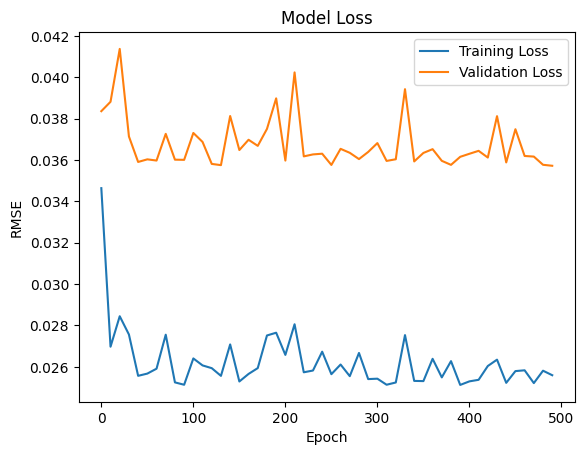

In [20]:
plt.plot(eval_epoch, train_losses, label="Training Loss")
plt.plot(eval_epoch, valid_losses, label="Validation Loss")
plt.title('Model Loss')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend()
# plt.savefig('graphs/train-validation-loss-lstm.png')
plt.show()

## Plotting Results of LSTM



In [23]:
with torch.no_grad():
    #Make predictions
    train_pred = model(X_train_tensor).cpu()
    valid_pred = model(X_valid_tensor).cpu()
    test_pred = model(X_test_tensor).cpu()

# Convert prediction tensor objects to np arrays
train_pred = train_pred.detach().numpy()
valid_pred = valid_pred.detach().numpy()
test_pred = test_pred.detach().numpy()

# Reshape np arrays
train_pred = train_pred.reshape(-1,1)
valid_pred = valid_pred.reshape(-1,1)
test_pred = test_pred.reshape(-1,1)

y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# Convert data and predictions to original scale
original_train_pred = scaler.inverse_transform(train_pred)
original_valid_pred = scaler.inverse_transform(valid_pred)
original_test_pred = scaler.inverse_transform(test_pred)

original_y_train = scaler.inverse_transform(y_train)
original_y_valid = scaler.inverse_transform(y_valid)
original_y_test = scaler.inverse_transform(y_test)

#Reshape
original_train_pred = original_train_pred.reshape(-1,1)
original_valid_pred = original_valid_pred.reshape(-1,1)
original_test_pred = original_test_pred.reshape(-1,1)

# Calculate Loss
rmse_train = np.sqrt(mean_squared_error(original_train_pred, original_y_train))
rmse_valid = np.sqrt(mean_squared_error(original_valid_pred, original_y_valid))
rmse_test = np.sqrt(mean_squared_error(original_test_pred, original_y_test))
print(f"train RMSE {rmse_train:.4f}, validation RMSE {rmse_valid:.4f}, test RMSE {rmse_test:.4f}")

train RMSE 25.9566, validation RMSE 35.9035, test RMSE 72.6600


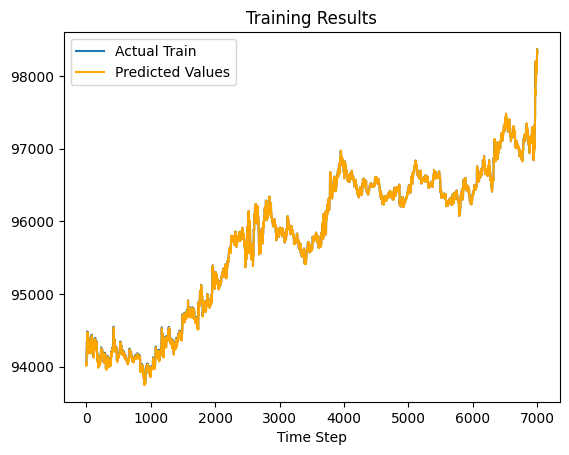

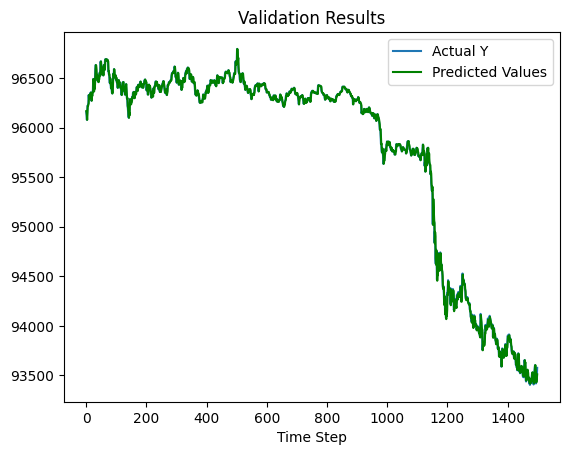

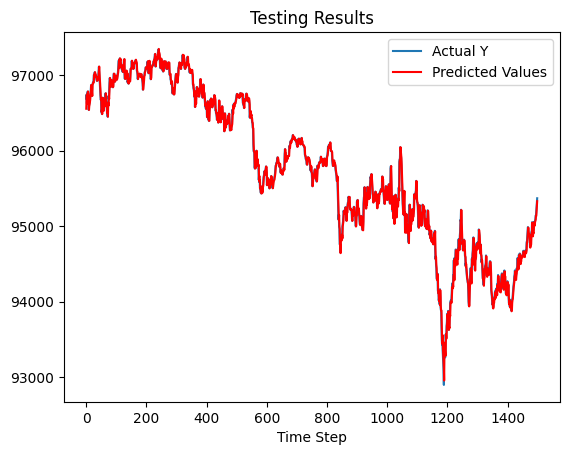

In [24]:

plt.plot(original_y_train, label="Actual Train")
plt.plot(original_train_pred, c='orange', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Training Results')
plt.legend()
plt.show()


plt.plot(original_y_valid, label="Actual Y")
plt.plot(original_valid_pred, c='green', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Validation Results')
plt.legend()
plt.show()


plt.plot(original_y_test, label="Actual Y")
plt.plot(original_test_pred, c='red', label="Predicted Values")
plt.xlabel('Time Step')
plt.title('Testing Results')
plt.legend()
plt.savefig("graphs/lstm-test-results.png")
plt.show()